# DATA PREPARATION AND CLEANING

In [30]:
from tqdm import tqdm
import pandas as pd
tqdm.pandas(bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
import time
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [2]:
# Load IMDb datasets
import pandas as pd

imdb_paths = {
    "name_basics": "data/IMDB/name.basics.tsv",
    "title_basics": "data/IMDB/title.basics.tsv",
    "title_crew": "data/IMDB/title.crew.tsv",
    "title_principals": "data/IMDB/title.principals.tsv", #NOT NEEDED
    "title_ratings": "data/IMDB/title.ratings.tsv",
}

imdb_data = {key: pd.read_csv(path, sep="\t", low_memory=False) for key, path in imdb_paths.items()}

In [3]:
# Filter IMDb data for movies and merge ratings
movies = imdb_data["title_basics"][imdb_data["title_basics"]["titleType"] == "movie"]
movies = movies.merge(imdb_data["title_ratings"], on="tconst", how="left")

# Convert startYear to numeric and filter
movies["startYear"] = pd.to_numeric(movies["startYear"], errors="coerce")
movies = movies[(movies["startYear"] >= 1980) & (movies["startYear"] <= 2023)]


In [58]:
movies_weighted.iloc[169775]

tconst                                                    tt8721424
primaryTitle                                    tick, tick... BOOM!
startYear                                                      2021
runtimeMinutes                                                  115
genres                                       Biography,Comedy,Drama
averageRating                                                   7.5
numVotes                                                     122359
actors            [Andrew Garfield, Alexandra Shipp, Robin de Je...
weightedScore                                              7.242301
Name: 397966, dtype: object

In [4]:
movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
5499,tt0011801,movie,Tötet nicht mehr,Tötet nicht mehr,0,2019.0,\N,\N,"Action,Crime",NaN,NaN
8525,tt0015414,movie,La tierra de los toros,La tierra de los toros,0,2000.0,\N,60,\N,5.4,17.0
8778,tt0015724,movie,Dama de noche,Dama de noche,0,1993.0,\N,102,"Drama,Mystery,Romance",6.3,31.0
24375,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,\N,118,"Comedy,Fantasy,Romance",6.4,90620.0
25336,tt0036606,movie,"Another Time, Another Place","Another Time, Another Place",0,1983.0,\N,118,"Drama,War",6.4,364.0


In [5]:
# Filter principals for relevant roles
imdb_principals = imdb_data["title_principals"]
imdb_names = imdb_data["name_basics"]

In [6]:
imdb_principals["category"].value_counts()

category
actor                  21366749
actress                16020910
self                   12834082
writer                 10749239
director                7709637
producer                6751394
editor                  4716832
cinematographer         3600121
composer                2914088
production_designer     1079806
casting_director        1051145
archive_footage          537974
archive_sound              8903
Name: count, dtype: int64

In [7]:
# Filter to keep actors, actresses
principal_roles = imdb_principals[imdb_principals["category"].isin(["actor", "actress"])]
principal_roles = principal_roles.merge(imdb_names, left_on="nconst", right_on="nconst", how="left")


In [8]:
principal_roles.head()

,tconst,ordering,nconst,category,job,characters,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,tt0000005,1,nm0443482,actor,\N,"[""Blacksmith""]",Charles Kayser,1878,1966,actor,\N
1,tt0000005,2,nm0653042,actor,\N,"[""Assistant""]",John Ott,1850,1931,actor,\N
2,tt0000007,1,nm0179163,actor,\N,\N,James J. Corbett,1866,1933,"actor,writer,archive_footage","tt0003730,tt0003116,tt0034778,tt0163131"
3,tt0000007,2,nm0183947,actor,\N,\N,Peter Courtney,1867,1896,actor,tt0000007
4,tt0000008,1,nm0653028,actor,\N,"[""Sneezing Man""]",Fred Ott,1860,1936,"assistant_director,archive_footage","tt0000008,tt0285265,tt0240514"


In [11]:
# Group and aggregate cast/crew information
principal_roles_agg = principal_roles.groupby("tconst")["primaryName"].apply(list).reset_index()
principal_roles_agg.rename(columns={"primaryName": "actors"}, inplace=True)
principal_roles_agg.head()

,tconst,actors
0,tt0000005,"[Charles Kayser, John Ott]"
1,tt0000007,"[James J. Corbett, Peter Courtney]"
2,tt0000008,[Fred Ott]
3,tt0000009,"[Blanche Bayliss, William Courtenay, Chauncey ..."
4,tt0000011,[Grunato]


In [12]:
# Merge actor info into movies
movies = movies.merge(principal_roles_agg, on="tconst", how="left")
movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,actors
0,tt0011801,movie,Tötet nicht mehr,Tötet nicht mehr,0,2019.0,\N,\N,"Action,Crime",NaN,NaN,"[Lupu Pick, Edith Posca, Johannes Riemann, Fri..."
1,tt0015414,movie,La tierra de los toros,La tierra de los toros,0,2000.0,\N,60,\N,5.4,17.0,NaN
2,tt0015724,movie,Dama de noche,Dama de noche,0,1993.0,\N,102,"Drama,Mystery,Romance",6.3,31.0,"[Rafael Sánchez Navarro, Cecilia Toussaint, Mi..."
3,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,\N,118,"Comedy,Fantasy,Romance",6.4,90620.0,"[Meg Ryan, Hugh Jackman, Liev Schreiber, Breck..."
4,tt0036606,movie,"Another Time, Another Place","Another Time, Another Place",0,1983.0,\N,118,"Drama,War",6.4,364.0,"[Phyllis Logan, Giovanni Mauriello, Gianluca F..."


In [13]:
# Extract necessary columns
movies = movies[["tconst", "primaryTitle", "startYear", "runtimeMinutes", "genres", "averageRating", "numVotes", "actors"]]
movies.to_csv("data/movies_v1.csv", index=False)

In [14]:
movies = pd.read_csv("data/movies_v1.csv")
display(movies.head())
display(len(movies))

,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,actors
0,tt0011801,Tötet nicht mehr,2019.0,\N,"Action,Crime",NaN,NaN,"['Lupu Pick', 'Edith Posca', 'Johannes Riemann..."
1,tt0015414,La tierra de los toros,2000.0,60,\N,5.4,17.0,NaN
2,tt0015724,Dama de noche,1993.0,102,"Drama,Mystery,Romance",6.3,31.0,"['Rafael Sánchez Navarro', 'Cecilia Toussaint'..."
3,tt0035423,Kate & Leopold,2001.0,118,"Comedy,Fantasy,Romance",6.4,90620.0,"['Meg Ryan', 'Hugh Jackman', 'Liev Schreiber',..."
4,tt0036606,"Another Time, Another Place",1983.0,118,"Drama,War",6.4,364.0,"['Phyllis Logan', 'Giovanni Mauriello', 'Gianl..."


411033

In [15]:
import numpy as np
# \N
movies.replace(to_replace=r"\\N", value=np.nan, regex=True, inplace=True)

In [16]:
# Count null values per column
null_counts = movies.isnull().sum()

# Display results
print("Null Values Per Column:")
print(null_counts)

Null Values Per Column:
tconst                 0
primaryTitle           2
startYear              0
runtimeMinutes     94919
genres             31207
averageRating     176793
numVotes          176793
actors            105353
dtype: int64


In [17]:
# Drop rows with NaN in `averageRating` or `numVotes`
movies_cleaned = movies.dropna(subset=["averageRating", "numVotes", "genres", "actors", "runtimeMinutes"])
display(movies_cleaned.head())
display(len(movies_cleaned))

,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,actors
2,tt0015724,Dama de noche,1993.0,102,"Drama,Mystery,Romance",6.3,31.0,"['Rafael Sánchez Navarro', 'Cecilia Toussaint'..."
3,tt0035423,Kate & Leopold,2001.0,118,"Comedy,Fantasy,Romance",6.4,90620.0,"['Meg Ryan', 'Hugh Jackman', 'Liev Schreiber',..."
4,tt0036606,"Another Time, Another Place",1983.0,118,"Drama,War",6.4,364.0,"['Phyllis Logan', 'Giovanni Mauriello', 'Gianl..."
6,tt0038687,Let There Be Light,1980.0,58,"Documentary,War",7.4,2063.0,['Walter Huston']
7,tt0057461,La rosa de los vientos,1983.0,84,"Drama,Fantasy",4.2,27.0,"['Patxi Andión', 'José Antonio Rodríguez', 'Ne..."


174935

In [18]:
# Convert data types
movies_cleaned["startYear"] = movies_cleaned["startYear"].astype(int, errors="ignore")
movies_cleaned["numVotes"] = movies_cleaned["numVotes"].astype(int)
movies_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174935 entries, 2 to 411031
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          174935 non-null  object 
 1   primaryTitle    174935 non-null  object 
 2   startYear       174935 non-null  int32  
 3   runtimeMinutes  174935 non-null  object 
 4   genres          174935 non-null  object 
 5   averageRating   174935 non-null  float64
 6   numVotes        174935 non-null  int32  
 7   actors          174935 non-null  object 
dtypes: float64(1), int32(2), object(5)
memory usage: 10.7+ MB


C:\Users\USER\AppData\Local\Temp\ipykernel_6904\289952093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_cleaned["startYear"] = movies_cleaned["startYear"].astype(int, errors="ignore")
C:\Users\USER\AppData\Local\Temp\ipykernel_6904\289952093.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_cleaned["numVotes"] = movies_cleaned["numVotes"].astype(int)


In [37]:
movies_cleaned.to_csv("data/movies_cleaned.csv", index=False)

# Exploratory Data Analysis

In [9]:
movies_cleaned = pd.read_csv("data/movies_cleaned.csv")
movies_cleaned.rename(columns={"cast_and_crew": "actors"}, inplace=True)
display(movies_cleaned.head())
display(len(movies_cleaned))

,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,actors
0,tt0015724,Dama de noche,1993,102,"Drama,Mystery,Romance",6.3,31,"['Rafael Sánchez Navarro', 'Cecilia Toussaint'..."
1,tt0035423,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",6.4,90620,"['Meg Ryan', 'Hugh Jackman', 'Liev Schreiber',..."
2,tt0036606,"Another Time, Another Place",1983,118,"Drama,War",6.4,364,"['Phyllis Logan', 'Giovanni Mauriello', 'Gianl..."
3,tt0038687,Let There Be Light,1980,58,"Documentary,War",7.4,2063,['Walter Huston']
4,tt0057461,La rosa de los vientos,1983,84,"Drama,Fantasy",4.2,27,"['Patxi Andión', 'José Antonio Rodríguez', 'Ne..."


174935

In [ ]:
display(movies_cleaned.describe())

## What is the HIGHEST RATED movie in 2023?

### Case 1: Based on 'highest' averageRating

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter movies for 2023
movies_2023 = movies_cleaned[movies_cleaned["startYear"] == 2023]

# Sort movies by average rating in descending order and select top 5
top_5_2023 = movies_2023.nlargest(5, "averageRating")

# Select important columns for display
top_5_2023_info = top_5_2023[["startYear", "primaryTitle", "averageRating", "numVotes", "genres", "actors"]].reset_index(drop=True)

# Display the DataFrame
print("Top 5 Highest-Rated Movies in 2023:")
display(top_5_2023_info)

Top 5 Highest-Rated Movies in 2023:


,startYear,primaryTitle,averageRating,numVotes,genres,actors
0,2023,Swapnaloka,10.0,13,Drama,"['Veeresh Kambayyagar', 'Annapurna KK', 'Kote ..."
1,2023,Giuseppe Garibaldi eroe leggendario,10.0,11,Documentary,['Alessandro Haber']
2,2023,Sisters and the Shrink 5,10.0,6,Drama,"['Brandon Oliver Ellis', 'Howard Horn', 'Cryst..."
3,2023,A Summer Night,9.9,24,Drama,"['Chuti Tiu', 'Roberto Sanchez', 'Clarissa Jac..."
4,2023,Cranedance A Story of Sandhill Cranes in Michigan,9.9,8,Documentary,['Larry Denninger']


In this case, the highest-rated movies in 2023 are **"Swapnaloka," "Giuseppe Garibaldi eroe leggendario," and "Sisters and the Shrink 5,"** each with a perfect average rating of 10.0. ***However, they have very low vote counts, making their ratings less representative.***

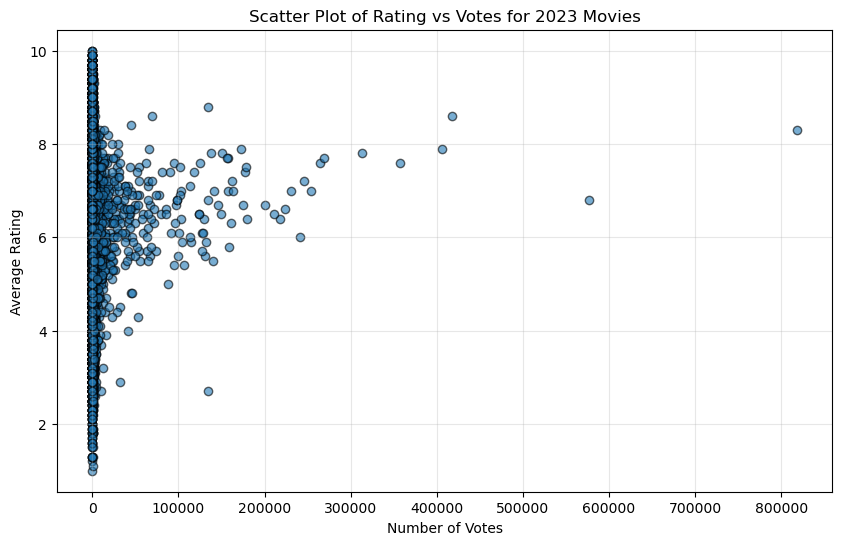

In [22]:
# Scatter plot of Rating vs Votes
plt.figure(figsize=(10, 6))
plt.scatter(movies_2023["numVotes"], movies_2023["averageRating"], alpha=0.6, edgecolor='k')
plt.title("Scatter Plot of Rating vs Votes for 2023 Movies")
plt.xlabel("Number of Votes")
plt.ylabel("Average Rating")
plt.grid(alpha=0.3)
plt.show()

***The distribution shows most movies have very few with votes, while a few receive hundreds of thousands, creating an imbalance. This is why balancing ratings and vote counts is critical—high ratings with few votes can be misleading, and sheer popularity shouldn’t overshadow quality. A weighted scoring system ensures rankings reflect both audience size and quality feedback fairly.***

#### How do we balance ratings and number of votes?
To balance ratings and votes, we can compute a weighted score using a common formula like the Bayesian average:

##### Weighted Score Formula

$$
\text{Weighted Score} = \frac{(\text{numVotes} \times \text{averageRating}) + (\text{minimumVotes} \times \text{globalAverage})}{\text{numVotes} + \text{minimumVotes}}
$$

The **weighted score formula** is derived from a common technique used to balance **popularity** and **quality** in rankings. It’s inspired by methods like the Bayesian average and IMDb’s own rating calculation, designed to adjust a movie’s rating based on the number of votes it has received. This formula ensures:
- **Fairness**: Movies with fewer votes are not overly penalized but also do not dominate the rankings.
- **Reliability**: Ratings with many votes are weighted more heavily, making them statistically more trustworthy.

*Defining the Minimum Votes (m)*
Why Use 25,000?
- Consistency with IMDb - Aligns with a well-established industry standard for identifying popular movies.
- Filters out movies with insufficient votes, ensuring the list reflects movies that are both highly rated and widely voted upon.

### Case 2: Based on average rating and number of votes using the Weighted Score Formula

In [21]:
# Compute global average rating and minimum votes threshold
global_average = movies_cleaned["averageRating"].mean()
minimum_votes = 25000  

# Add a weighted score column
movies_cleaned["weightedScore"] = (
    (movies_cleaned["numVotes"] * movies_cleaned["averageRating"]) +
    (minimum_votes * global_average)
) / (movies_cleaned["numVotes"] + minimum_votes)

movies_2023 = movies_cleaned[movies_cleaned["startYear"] == 2023]

# Top 5 movies by weighted score
top_weighted_movies = movies_2023.nlargest(10, "weightedScore")

print("Top 5 Movies by Weighted Score:")
display(top_weighted_movies[["tconst","primaryTitle", "runtimeMinutes", "averageRating", "numVotes", "weightedScore","actors","genres"]])

Top 5 Movies by Weighted Score:


C:\Users\USER\AppData\Local\Temp\ipykernel_6904\1405880189.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_cleaned["weightedScore"] = (


,tconst,primaryTitle,runtimeMinutes,averageRating,numVotes,weightedScore,actors,genres
405575,tt9362722,Spider-Man: Across the Spider-Verse,140,8.6,417620,8.452076,"['Shameik Moore', 'Hailee Steinfeld', 'Brian T...","Action,Adventure,Animation"
249085,tt23849204,12th Fail,147,8.8,134765,8.358888,"['Vikrant Massey', 'Medha Shankr', 'Anant Josh...","Biography,Drama"
181977,tt15398776,Oppenheimer,180,8.3,817891,8.231220,"['Cillian Murphy', 'Emily Blunt', 'Matt Damon'...","Biography,Drama,History"
269471,tt27719898,Kaiva,138,8.6,68927,7.902924,"['Dharmendra Aras', 'Agratha Ashok', 'Anand Ba...","Action,Drama,Romance"
371488,tt6791350,Guardians of the Galaxy Vol. 3,150,7.9,406355,7.788782,"['Chris Pratt', 'Chris Pratt', 'Chukwudi Iwuji...","Action,Adventure,Comedy"
163996,tt14230458,Poor Things,141,7.8,313181,7.665533,"['Emma Stone', 'Mark Ruffalo', 'Willem Dafoe',...","Comedy,Drama,Romance"
173867,tt14849194,The Holdovers,133,7.9,172447,7.657027,"['Paul Giamatti', ""Da'Vine Joy Randolph"", 'Dom...","Comedy,Drama"
407609,tt9603212,Mission: Impossible - Dead Reckoning Part One,163,7.7,269267,7.553962,"['Tom Cruise', 'Hayley Atwell', 'Ving Rhames',...","Action,Adventure,Thriller"
192448,tt16277242,Society of the Snow,144,7.8,150416,7.540763,"['Enzo Vogrincic', 'Agustín Pardella', 'Matías...","Adventure,Biography,Drama"
232218,tt21626284,Lost Ladies,122,8.4,45188,7.538396,"['Nitanshi Goel', 'Pratibha Ranta', 'Sparsh Sh...","Comedy,Drama"


**HIGHEST RATED movie in 2023: [ Spider-Man: Across the Spider-Verse ]**

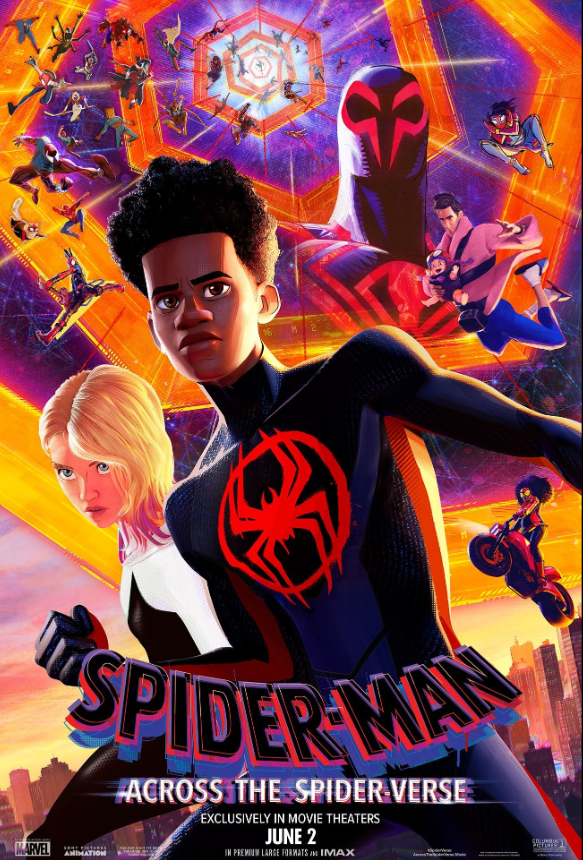

https://www.imdb.com/title/tt9362722/mediaviewer/rm1009725185/?ref_=tt_ov_i

This approach balances ratings and number of votes, ensuring movies with broader audience feedback rank higher, making the results more reliable and representative.

#### Distrribution of Weighted Scores in 2023

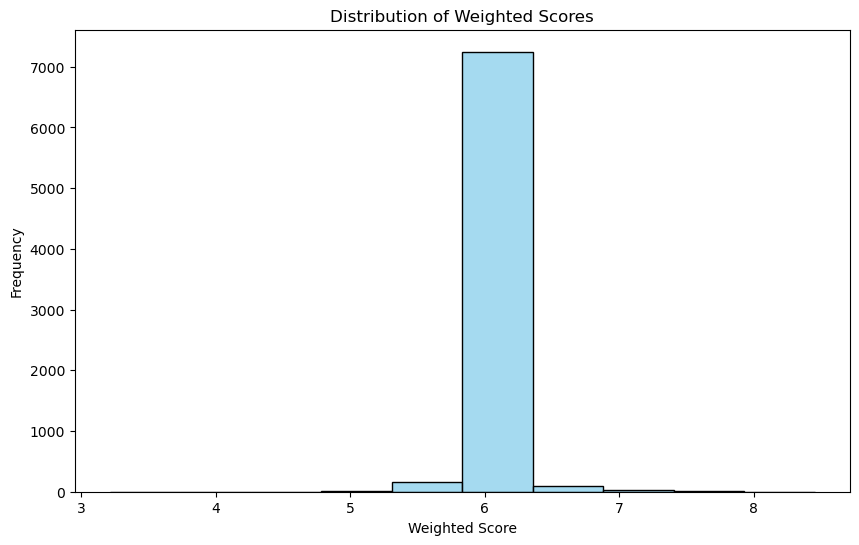

Summary Statistics for Weighted Scores:
count    7558.000000
mean        5.993258
std         0.143829
min         3.213839
25%         5.977511
50%         5.981521
75%         5.984864
max         8.452076
Name: weightedScore, dtype: float64


In [26]:
movies_2023 = movies_cleaned[movies_cleaned["startYear"] >= 2023]

# Plot the distribution of numVotes
plt.figure(figsize=(10, 6))
sns.histplot(movies_2023["weightedScore"], bins=10, kde=False, color="skyblue")
plt.title("Distribution of Weighted Scores")
plt.xlabel("Weighted Score")
plt.ylabel("Frequency")
plt.show()

# Summary statistics
print("Summary Statistics for Weighted Scores:")
print(movies_2023["weightedScore"].describe())



***The distribution shows that movies with high weighted scores (7 and above) are extremely rare. Most movies hover around the average score of 6, which suggests that only a few films manage to balance high ratings and significant audience reach. This rarity highlights how exceptional these top movies are, making the balance between ratings and votes crucial to identify them fairly.***

## Most Popular Actor in 2023 by Average Votes (User Interaction)

In [12]:
import ast
# Convert `actors` from object (string) to actual lists
movies_cleaned["actors"] = movies_cleaned["actors"].apply(ast.literal_eval)
movies_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174935 entries, 0 to 174934
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          174935 non-null  object 
 1   primaryTitle    174935 non-null  object 
 2   startYear       174935 non-null  int64  
 3   runtimeMinutes  174935 non-null  int64  
 4   genres          174935 non-null  object 
 5   averageRating   174935 non-null  float64
 6   numVotes        174935 non-null  int64  
 7   actors          174935 non-null  object 
 8   weightedScore   174935 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 12.0+ MB


In [ ]:
movies_cleaned["actors"] = movies_cleaned["actors"].apply(ast.literal_eval)

In [33]:
# Filter for movies in 2023
movies_2023 = movies_cleaned[movies_cleaned["startYear"] >= 2023]

# Explode the `actors` column to associate movies with individual actors
actors_exploded = movies_2023.explode("actors")

# Group by actor to calculate the total and average number of votes
actor_stats_votes = actors_exploded.groupby("actors").agg(
    total_votes=("numVotes", "sum"),     # Total votes across all movies
    average_votes=("numVotes", "mean"), # Average votes per movie
    movie_count=("primaryTitle", "count") # Total number of movies
).reset_index()

# Sort actors by total votes (or average votes for a different perspective)
actor_stats_votes = actor_stats_votes.sort_values("average_votes", ascending=False)

# Display the top 5 actors by total votes
print("Top 5 Actors in 2023 by Average Votes:")
display(actor_stats_votes.head(10))


Top 5 Actors in 2023 by Average Votes:


,actors,total_votes,average_votes,movie_count
43512,Scott Grimes,817891,817891.0,1
41063,Robert Downey Jr.,817891,817891.0,1
27046,Kurt Koehler,817891,817891.0,1
23094,John Gowans,817891,817891.0,1
44320,Sharon Rooney,576291,576291.0,1
25320,Kate McKinnon,576291,576291.0,1
42021,Ryan Gosling,576291,576291.0,1
14580,Emma Mackey,576291,576291.0,1
2835,Ana Cruz Kayne,576291,576291.0,1
30654,Margot Robbie,576291,576291.0,1


**Observations:**
- John Gowans, Robert Downey Jr., Kurt Koehler, and Scott Grimes tied at the top, each with an identical average_votes of 817,891, likely from one highly voted movie.
- Sharon Rooney, et. al follows, with a lower but still notable average_votes.

From my perspective, this result highlights how a single blockbuster movie can drastically influence an actor's popularity metrics. The methodology effectively isolates user interaction intensity (via votes) and avoids inflating rankings due to actors with numerous low-vote movies.

### Most Popular Actor in 2023 by Total Votes (User Interaction)

In [35]:
# Filter for movies in 2023
movies_2023 = movies_cleaned[movies_cleaned["startYear"] >= 2023]

# Explode the `actors` column to associate movies with individual actors
actors_exploded = movies_2023.explode("actors")
# Group by actor to calculate the total and average number of votes
actor_stats_votes = actors_exploded.groupby("actors").agg(
    total_votes=("numVotes", "sum"),     # Total votes across all movies
    average_votes=("numVotes", "mean"), # Average votes per movie
    movie_count=("primaryTitle", "count") # Total number of movies
).reset_index()

# Sort actors by total votes (or average votes for a different perspective)
actor_stats_votes = actor_stats_votes.sort_values("total_votes", ascending=False)

# Display the top 5 actors by total votes
print("Top 5 Actors in 2023 by Total Votes:")
display(actor_stats_votes.head(5))


Top 5 Actors in 2023 by Total Votes:


,actors,total_votes,average_votes,movie_count
20162,Issa Rae,1095573,365191.000000,3
9576,Chris Pratt,1066171,355390.333333,3
31908,Matt Damon,995122,497561.000000,2
1364,Alden Ehrenreich,974305,324768.333333,3
48512,Tony Goldwyn,903794,451897.000000,2


In [39]:
actors_exploded[actors_exploded["actors"]=='Issa Rae']

,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,actors,weightedScore
178431,tt1517268,Barbie,2023,114,"Adventure,Comedy,Fantasy",6.8,576291,Issa Rae,6.765949
246685,tt23561236,American Fiction,2023,117,"Comedy,Drama",7.5,101662,Issa Rae,7.200192
405575,tt9362722,Spider-Man: Across the Spider-Verse,2023,140,"Action,Adventure,Animation",8.6,417620,Issa Rae,8.452076


In 2023, Issa Rae stood out as the most popular actor based on total votes, high-quality movie appearances, and her involvement in projects spanning diverse genres. Her ability to be part of widely successful movies like Spider-Man: Across the Spider-Verse further solidified her status as a top actor for the year.

## Trends

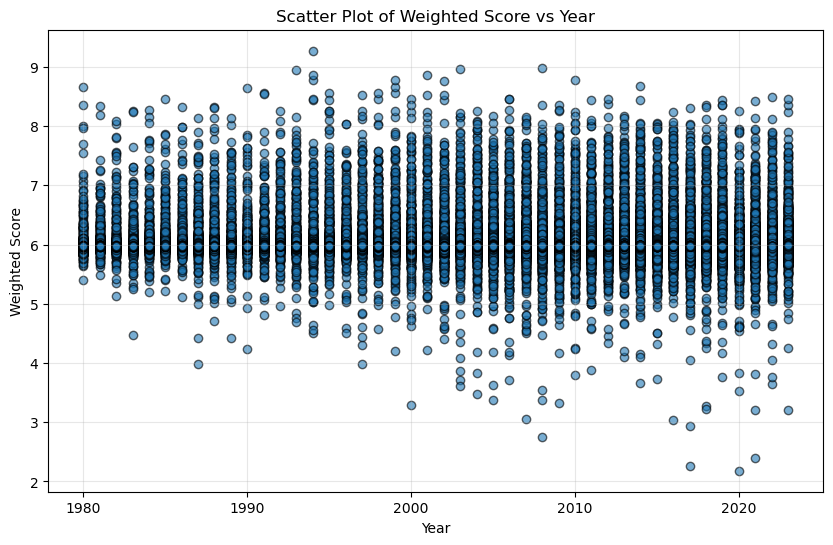

In [25]:
# Scatter plot of Weighted Score vs Year
plt.figure(figsize=(10, 6))
plt.scatter(movies_cleaned["startYear"], movies_cleaned["weightedScore"], alpha=0.6, edgecolor='k')
plt.title("Scatter Plot of Weighted Score vs Year")
plt.xlabel("Year")
plt.ylabel("Weighted Score")
plt.grid(alpha=0.3)
plt.show()

- The wide range of scores in each year reflects the diversity of audience preferences and movie quality.
- The clustering around 6 to 7 suggests these scores are the norm for most movies, making high-scoring movies (>8) standout examples of success.
- The increased density in later years may be attributed to technological advancements and easier access to movies globally.

### Distribution of Genres Over Time

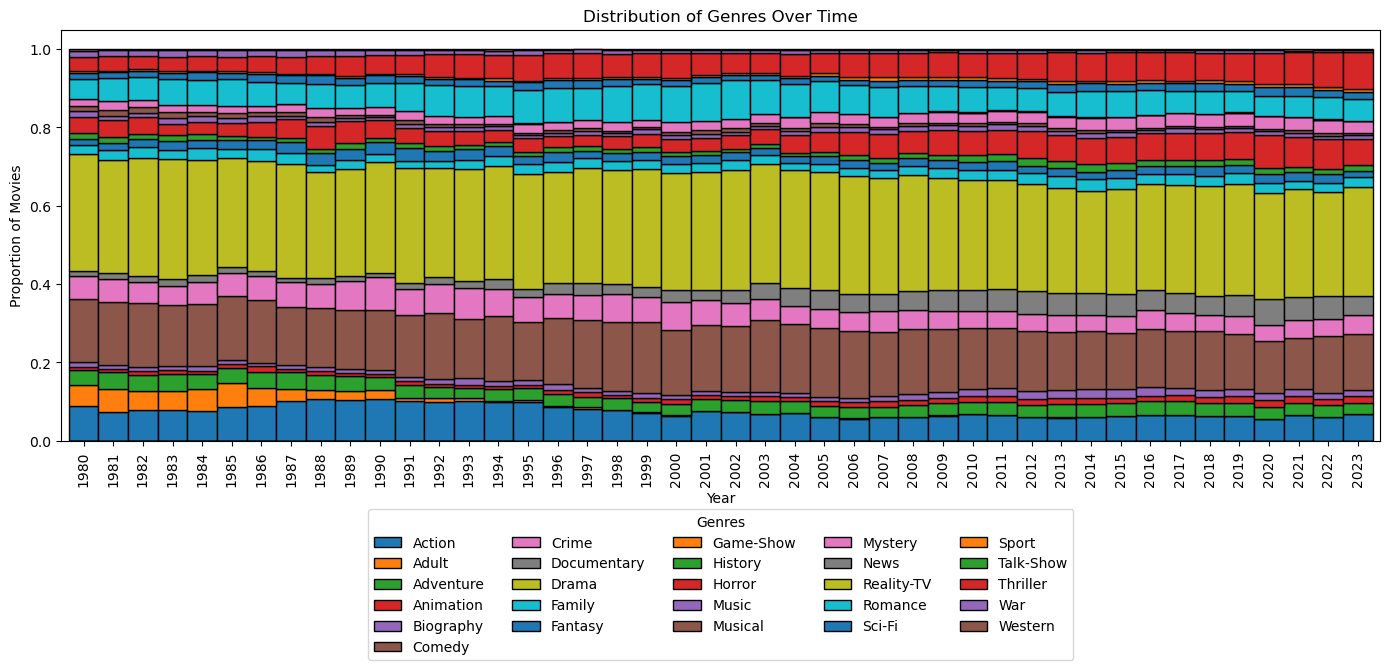

In [53]:
# Explode genres for analysis
movies_exploded = movies_cleaned.copy()
movies_exploded["genres"] = movies_exploded["genres"].str.split(",")
movies_exploded = movies_exploded.explode("genres")

# Group by genre and year to calculate proportions
genre_counts_per_year = movies_exploded.groupby(["startYear", "genres"]).size().reset_index(name="count")
total_counts_per_year = movies_exploded.groupby("startYear").size().reset_index(name="total_count")

# Merge and calculate proportions
genre_distribution = genre_counts_per_year.merge(total_counts_per_year, on="startYear")
genre_distribution["proportion"] = genre_distribution["count"] / genre_distribution["total_count"]

# # Plot distribution of genres over time
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=genre_distribution, x="startYear", y="proportion", hue="genres")
# plt.title("Distribution of Genres Over Time")
# plt.xlabel("Year")
# plt.ylabel("Proportion of Movies")
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.show()

# Pivot the data to prepare for bar plotting
genre_distribution_pivot = genre_distribution.pivot(index="startYear", columns="genres", values="proportion").fillna(0)

# Plot a stacked bar chart
genre_distribution_pivot.plot(kind="bar", stacked=True, figsize=(14, 7), width=1, edgecolor="k")
plt.title("Distribution of Genres Over Time")
plt.xlabel("Year")
plt.ylabel("Proportion of Movies")
plt.legend(title="Genres", bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=5)
plt.tight_layout()
plt.show()

- The dominance of Drama and Comedy aligns with these genres being versatile and widely appealing.
- Certain genres (e.g., Sci-Fi, Adventure) may correlate with technological advances or changes in audience preferences.
- The decline of Westerns reflects a shift in audience interest over time.
  
This chart helps identify long-term trends in movie genre popularity and how cultural, technological, and societal factors might influence these trends. It could be useful for predicting future genre trends or analyzing shifts in audience preferences over time.

### Top 10 Genres with Most User Interaction (Votes) Over the Years

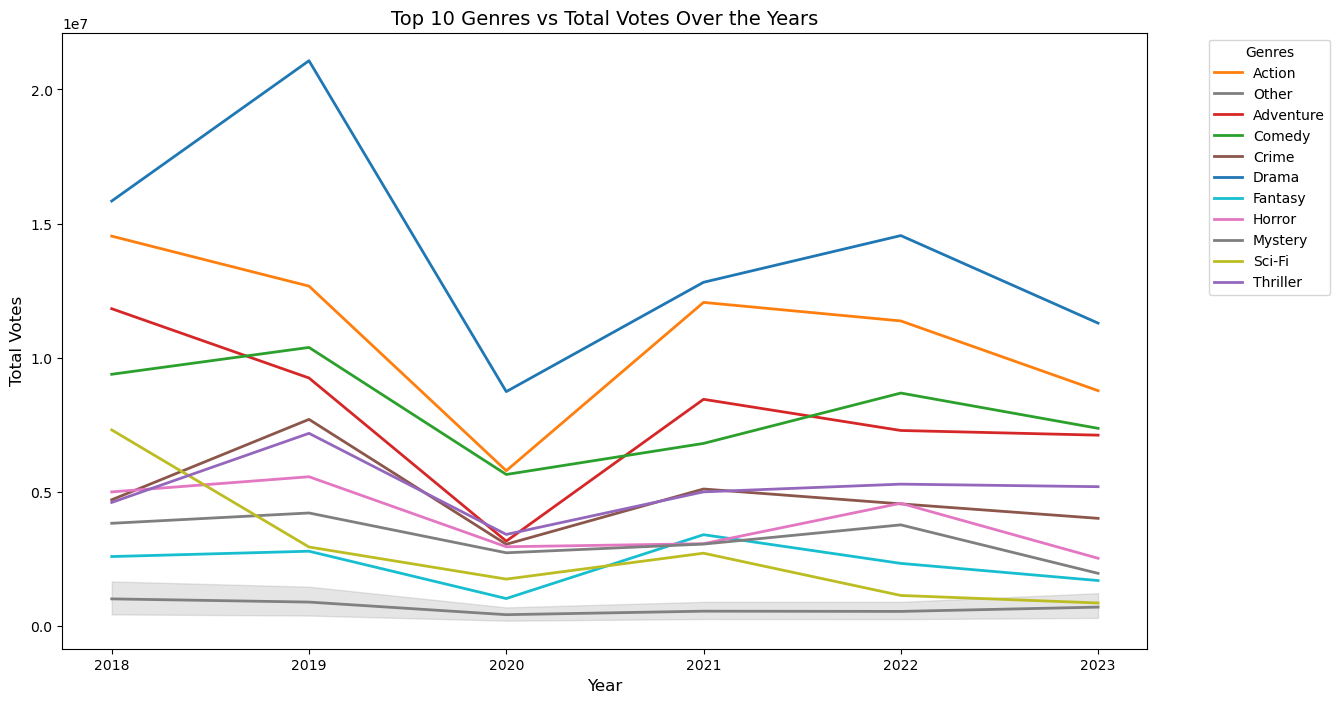

In [44]:
genre_votes_trends = movies_exploded.groupby(["startYear", "genres"]).agg(
    total_votes=("numVotes", "sum")  # Sum of votes for each genre per year
).reset_index()

genre_votes_trends = genre_votes_trends[genre_votes_trends["startYear"]>=2018]

# Get the top 10 genres by total votes across all years
top_genres = genre_votes_trends.groupby("genres")["total_votes"].sum().nlargest(10).index

# Add a column to mark whether a genre is in the top 10 or not
genre_votes_trends["is_top_genre"] = genre_votes_trends["genres"].apply(
    lambda x: x if x in top_genres else "Other"
)

# Plot with seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=genre_votes_trends,
    x="startYear",
    y="total_votes",
    hue="is_top_genre",
    palette={**{genre: sns.color_palette("tab10")[i] for i, genre in enumerate(top_genres)}, "Other": "gray"},
    linewidth=2
)
plt.title("Top 10 Genres vs Total Votes Over the Years", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Votes", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Genres")
plt.show()


This chart shows **how audience engagement (total votes) has shifted across movie genres over time**. 
- Action and Adventure continue to dominate, proving their resilience and reliability for studios aiming for large-scale appeal.
- Sci-Fi's stagnation after 2021 indicates a need for fresh narratives or cross-genre blending to reignite audience interest.
- Niche genres like Fantasy and Mystery could be emerging opportunities, appealing to specific audience demographics post-pandemic.

# Defining a Metric for a "Hit Movie"

A successful movie for a studio balances financial profitability, audience satisfaction, and cultural impact. To capture this, we propose the AAA Movie Score (AMS) to guide decision-making and predict potential AAA titles. Below is a proposed metric:

## Hit Movie Metric: AAA Movie Score (AMS)

### Formula:

AMS=(Normalized Box Office Revenue)+(Optimized Rating)+(Social Media Engagement Score)

### Components:
- **Box Office Revenue**: Reflects financial success; normalized to compare across different budgets.
- **Rating**: Captures audience satisfaction and quality perception.
- **Social Media Engagement Score**: Indicates buzz and cultural impact, derived from social media mentions, likes, and shares.


For this project, the **Rating** is optimized to ensure movies meet a certain AAA threshold, enabling studios to prioritize projects with the highest potential for critical and commercial success.

### AAA Title Rating Threshold
By selecting movies rated **7.0 or higher**, we’re targeting the **top 0.8%** of the IMDb dataset — a small, highly selective group that consistently delivers both critical and audience acclaim. This approach ensures our analysis focuses on films with proven success metrics, aligning with the goals of predicting the next triple-A title.

In [55]:
movies_weighted = movies_cleaned.copy()
movies_weighted.head(1)

,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,actors,weightedScore
2,tt0015724,Dama de noche,1993,102,"Drama,Mystery,Romance",6.3,31,"[Rafael Sánchez Navarro, Cecilia Toussaint, Mi...",5.981423


In [16]:
movies_weighted["highRated"] = (movies_weighted["weightedScore"] >= 7).astype(int)
movies_weighted.head()

,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,actors,weightedScore,highRated
0,tt0015724,Dama de noche,1993,102,"Drama,Mystery,Romance",6.3,31,"['Rafael Sánchez Navarro', 'Cecilia Toussaint'...",5.981423,0
1,tt0035423,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",6.4,90620,"['Meg Ryan', 'Hugh Jackman', 'Liev Schreiber',...",6.309408,0
2,tt0036606,"Another Time, Another Place",1983,118,"Drama,War",6.4,364,"['Phyllis Logan', 'Giovanni Mauriello', 'Gianl...",5.987041,0
3,tt0038687,Let There Be Light,1980,58,"Documentary,War",7.4,2063,['Walter Huston'],6.089196,0
4,tt0057461,La rosa de los vientos,1983,84,"Drama,Fantasy",4.2,27,"['Patxi Andión', 'José Antonio Rodríguez', 'Ne...",5.979107,0


In [17]:
display(movies_weighted[movies_weighted["highRated"]==1].head())
display(len(movies_weighted[movies_weighted["highRated"]==1]))

,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,actors,weightedScore,highRated
40,tt0076276,Who's Singin' Over There?,1980,86,"Adventure,Comedy,Drama",8.7,16955,"['Pavle Vuisic', 'Dragan Nikolic', ""Danilo 'Ba...",7.079829,1
271,tt0080339,Airplane!,1980,88,Comedy,7.7,267834,"['Robert Hays', 'Julie Hagerty', 'Leslie Niels...",7.553247,1
336,tt0080455,The Blues Brothers,1980,133,"Action,Adventure,Comedy",7.9,218566,"['John Belushi', 'Dan Aykroyd', 'Cab Calloway'...",7.703034,1
358,tt0080487,Caddyshack,1980,98,"Comedy,Sport",7.2,129531,"['Chevy Chase', 'Rodney Dangerfield', 'Bill Mu...",7.002795,1
474,tt0080678,The Elephant Man,1980,124,"Biography,Drama",8.2,264124,"['Anthony Hopkins', 'John Hurt', 'Anne Bancrof...",8.008130,1


1399

In [32]:
movies_weighted.to_csv("data/movies_weighted.csv", index=False)

In [40]:
movies_weighted.columns

Index(['tconst', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres',
       'averageRating', 'numVotes', 'cast_and_crew', 'weightedScore',
       'highRated'],
      dtype='object')

In [18]:

movies_df = movies_weighted.copy()
# Split genres into multiple rows for proper grouping
movies_df['genres'] = movies_df['genres'].str.split(',')
movies_exploded = movies_df.explode('genres')

# Group by genres and calculate the count of high-rated movies
high_rated_counts = movies_exploded.groupby('genres')['highRated'].sum().reset_index()

# Rename columns for clarity
high_rated_counts.columns = ['Genre', 'HighRatedCount']

# Sort the results by the count of high-rated movies
high_rated_counts = high_rated_counts.sort_values(by='HighRatedCount', ascending=False)

# Display the results
print(high_rated_counts)


          Genre  HighRatedCount
8         Drama             988
5        Comedy             371
0        Action             359
6         Crime             301
2     Adventure             291
23     Thriller             197
19      Romance             176
4     Biography             173
16      Mystery             137
3     Animation             124
20       Sci-Fi             102
10      Fantasy              91
12      History              74
9        Family              64
13       Horror              62
14        Music              44
24          War              41
21        Sport              30
15      Musical              15
7   Documentary              13
25      Western               4
17         News               0
18   Reality-TV               0
1         Adult               0
11    Game-Show               0
22    Talk-Show               0


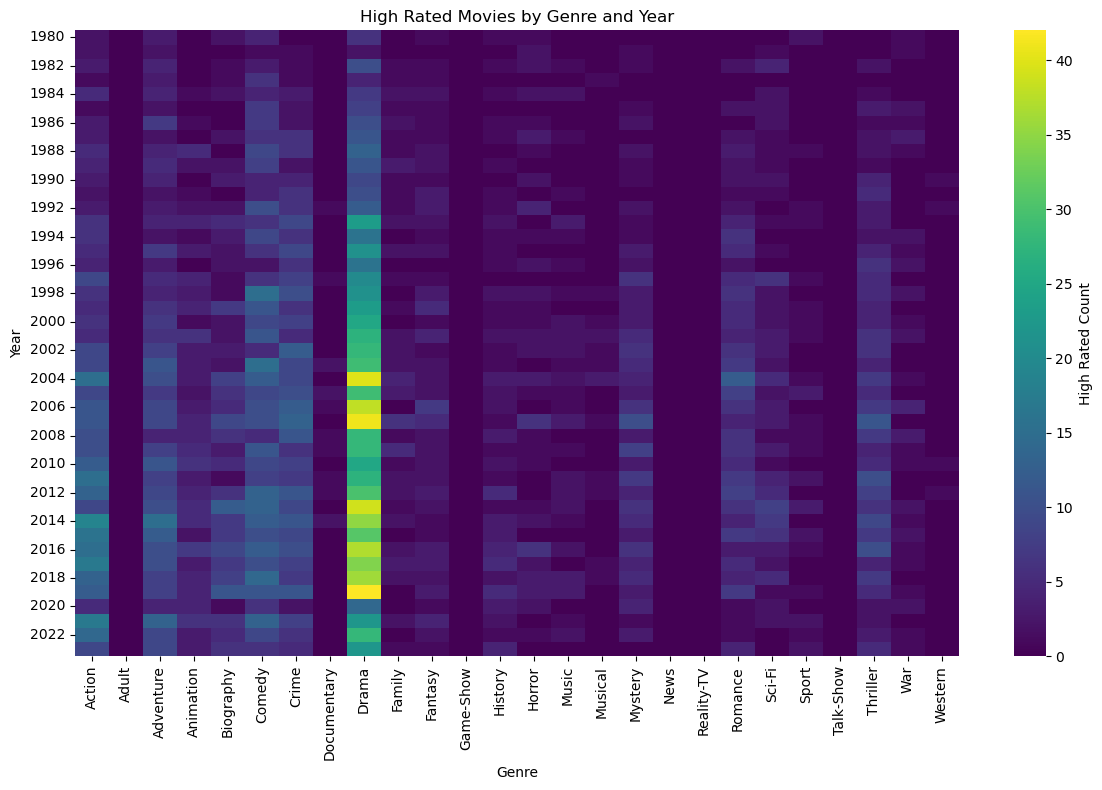

In [19]:
movies_df = movies_weighted.copy()
# Split genres into multiple rows for proper grouping
movies_df['genres'] = movies_df['genres'].str.split(',')
movies_exploded = movies_df.explode('genres')

# Group by genres and startYear, and calculate the count of high-rated movies
high_rated_by_genre_year = (
    movies_exploded.groupby(['genres', 'startYear'])['highRated']
    .sum()
    .reset_index()
)

# Pivot the data for a heatmap
heatmap_data = high_rated_by_genre_year.pivot(index='startYear', columns='genres', values='highRated').fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=False, cbar_kws={'label': 'High Rated Count'})
plt.title('High Rated Movies by Genre and Year')
plt.xlabel('Genre')
plt.ylabel('Year')
plt.tight_layout()
plt.show()


**Key Observations from the Heatmap**

1. Dominant Genres:
   - Drama: This genre has the highest concentration of high-rated movies over time, particularly between 2000 and 2020.
   - Documentary: Consistently contributes a significant number of high-rated movies, especially from 2005 onward.
   - Biography: Shows a steady increase in high-rated movies over recent years.
2. Less Significant Genres:
   - Genres like Game-Show, Reality-TV, Talk-Show, News, and Adult have little to no contribution to high-rated movies.
3. Emerging Trends:
   - Certain genres, like Crime, Thriller, and Horror, have sporadic contributions, suggesting they may be less dominant overall but could be important for niche predictions.


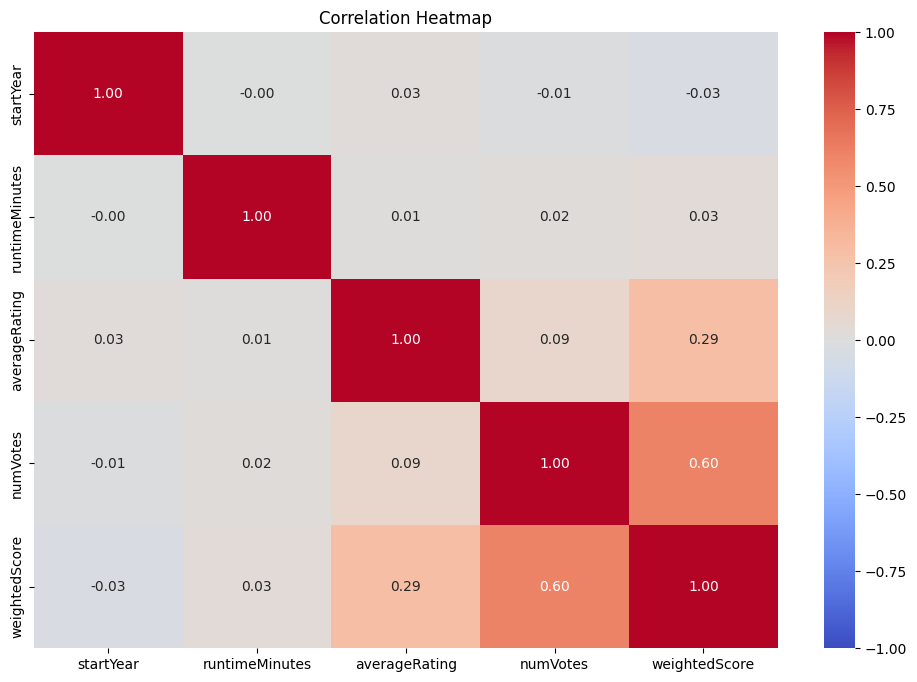

In [47]:
# Select numerical columns for correlation analysis
correlation_columns = [
    'startYear', 'runtimeMinutes','averageRating', 'numVotes', 'weightedScore'  # Example genres
]

# Filter the dataset
correlation_data = movies_weighted[correlation_columns]

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()


This heatmap suggests that numVotes and averageRating are influential predictors for weightedScore. Other features like runtimeMinutes and startYear have minimal impact based on their weak correlations.
- Moderate positive correlation (0.29): Higher ratings contribute to higher weighted scores.
- Strong positive correlation (0.60): More votes significantly influence the weighted score.
- Other features like runtimeMinutes and startYear show weak or no significant correlation with the other variables.